***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

DONE loading MixUp Data generator
DONE loading MixUp Data generator


# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\GitHub Repo\HDeep_CapsNet\code\training\CU_bird
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "2" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  2
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 16,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": 'adam',
                "loss_function": models.MarginLoss(),
               }

# Import Dataset : CU BIRD

In [5]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.CU_Birds_200_2011(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = 'mixup', # 'mixup'
                                                                                  data_normalizing = None) #'normalize'

In [6]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

In [7]:
from src.models import *

In [8]:
## For Dynamic LossWeights
initial_lw = initial_lw({"coarse": info['Num_Coarse'],
                         "medium": info['Num_Medium'],
                         "fine": info['Num_Fine']})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

## Learning Rate Decay Scheduler

In [9]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [10]:
Matrix_coarse_to_medium_OneHot = tf.constant(info['Matrix_coarse_to_medium'], dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(info['Matrix_medium_to_fine'], dtype=tf.float32)

In [11]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,
               number_of_classes_m, number_of_classes_f, C_Weight=0.2):
    
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = margin_loss(y_true_m, y_pred_m)*LW_M
    ML_f = margin_loss(y_true_f, y_pred_f)*LW_F
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [12]:
def get_compiled_model():
    input_shape = image_shape

    input_shape_yc = coarse_label_shape
    input_shape_ym = medium_label_shape
    input_shape_yf = fine_label_shape

    no_coarse_class = info['Num_Coarse']
    no_medium_class = info['Num_Medium']
    no_fine_class = info['Num_Fine']

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 16
    SCap_c_dims = 16


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]

    reshape = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(squash, name='p_caps')(reshape)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_f)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_m)

    pred_c = LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(
        inputs= [x_input, y_c, y_m, y_f],
        outputs= [pred_c, pred_m, pred_f],
        name='HD-CapsNet')
    
    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                             info['Num_Medium'],info['Num_Fine']))
    
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
                 )
    return model

## Compile Model

In [13]:
model = get_compiled_model()

## log directory

In [14]:
directory = sysenv.log_dir('HD_CapsNet/WO_C_loss')

FOLDER CREATED =  ./logs/HD_CapsNet/WO_C_loss


In [15]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 123)         0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 123)         0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 39)           0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 39)          0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 200)          0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

## Training Pipeline Alignment

In [16]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)
### matchin X,Y with model input
training_dataset_match = training_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = val_dataset.map(pipeline_multi_input_output) ## Val Dataset

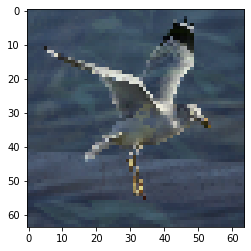

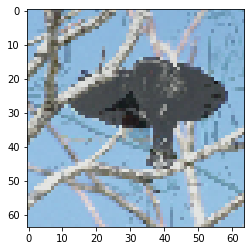

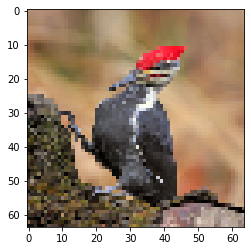

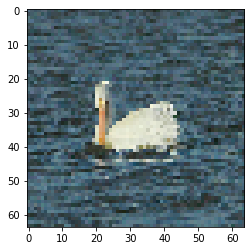

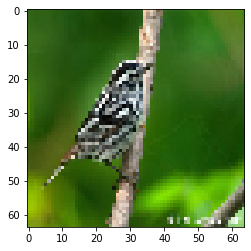

In [17]:
for x,y in training_dataset_match.take(5):
    plt.imshow(x[0][0])
    plt.show()
    

## Callback

In [18]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/weights-{epoch:02d}.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [19]:
history = model.fit(training_dataset_match,
                    epochs = train_params["n_epochs"],
                    validation_data = val_dataset_match,
                    callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                    verbose=1)

model_save_dir = str(directory+'/trained_model.h5')
try:
    model.save_weights(model_save_dir)
    print('Trained model saved to = ', model_save_dir)
except:
    print('Model Wight is not saved')

Epoch 1/100
375/375 [==============================] - ETA: 0s - loss: 0.7822 - prediction_coarse_accuracy: 0.0052 - prediction_medium_accuracy: 0.0128 - prediction_fine_accuracy: 0.0205
  • Coarse Accuracy = 0.52% | Val_Accuracy = 0.48% | LossWeight = 0.45 
  • Medium Accuracy = 1.28% | Val_Accuracy = 3.42% | LossWeight = 0.33 
  • Fine   Accuracy = 2.05% | Val_Accuracy = 1.76% | LossWeight = 0.22 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.01760, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-01.h5
375/375 [==============================] - 173s 396ms/step - loss: 0.7822 - prediction_coarse_accuracy: 0.0052 - prediction_medium_accuracy: 0.0128 - prediction_fine_accuracy: 0.0205 - val_loss: 0.7788 - val_prediction_coarse_accuracy: 0.0048 - val_prediction_medium_accuracy: 0.0342 - val_prediction_fine_accuracy: 0.0176 - lr: 0.0010
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 0.7680 - prediction_coarse_accuracy: 0.0130 - prediction_mediu

375/375 [==============================] - 157s 401ms/step - loss: 0.5004 - prediction_coarse_accuracy: 0.3605 - prediction_medium_accuracy: 0.2236 - prediction_fine_accuracy: 0.6555 - val_loss: 0.5540 - val_prediction_coarse_accuracy: 0.3183 - val_prediction_medium_accuracy: 0.1581 - val_prediction_fine_accuracy: 0.1122 - lr: 0.0010
Epoch 10/100
375/375 [==============================] - ETA: 0s - loss: 0.4785 - prediction_coarse_accuracy: 0.4092 - prediction_medium_accuracy: 0.2628 - prediction_fine_accuracy: 0.6760
  • Coarse Accuracy = 40.92% | Val_Accuracy = 33.17% | LossWeight = 0.45 
  • Medium Accuracy = 26.28% | Val_Accuracy = 17.67% | LossWeight = 0.42 
  • Fine   Accuracy = 67.60% | Val_Accuracy = 11.08% | LossWeight = 0.13 

Epoch 10: val_prediction_fine_accuracy did not improve from 0.11219
375/375 [==============================] - 157s 399ms/step - loss: 0.4785 - prediction_coarse_accuracy: 0.4092 - prediction_medium_accuracy: 0.2628 - prediction_fine_accuracy: 0.6760 - 

Epoch 19/100
375/375 [==============================] - ETA: 0s - loss: 0.2024 - prediction_coarse_accuracy: 0.8720 - prediction_medium_accuracy: 0.8735 - prediction_fine_accuracy: 0.9117
  • Coarse Accuracy = 87.20% | Val_Accuracy = 41.08% | LossWeight = 0.48 
  • Medium Accuracy = 87.35% | Val_Accuracy = 23.71% | LossWeight = 0.35 
  • Fine   Accuracy = 91.17% | Val_Accuracy = 13.32% | LossWeight = 0.17 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 157s 401ms/step - loss: 0.2024 - prediction_coarse_accuracy: 0.8720 - prediction_medium_accuracy: 0.8735 - prediction_fine_accuracy: 0.9117 - val_loss: 0.5391 - val_prediction_coarse_accuracy: 0.4108 - val_prediction_medium_accuracy: 0.2371 - val_prediction_fine_accuracy: 0.1332 - lr: 6.3025e-04
Epoch 20/100
375/375 [==============================] - ETA: 0s - loss: 0.1866 - prediction_coarse_accuracy: 0.9047 - prediction_medium_accuracy: 0.9036 - prediction_fine_accuracy: 

375/375 [==============================] - 156s 399ms/step - loss: 0.1234 - prediction_coarse_accuracy: 0.9585 - prediction_medium_accuracy: 0.9616 - prediction_fine_accuracy: 0.9615 - val_loss: 0.5793 - val_prediction_coarse_accuracy: 0.3935 - val_prediction_medium_accuracy: 0.2458 - val_prediction_fine_accuracy: 0.1360 - lr: 3.9721e-04
Epoch 29/100
375/375 [==============================] - ETA: 0s - loss: 0.1134 - prediction_coarse_accuracy: 0.9693 - prediction_medium_accuracy: 0.9705 - prediction_fine_accuracy: 0.9728
  • Coarse Accuracy = 96.93% | Val_Accuracy = 39.97% | LossWeight = 0.46 
  • Medium Accuracy = 97.05% | Val_Accuracy = 23.92% | LossWeight = 0.33 
  • Fine   Accuracy = 97.28% | Val_Accuracy = 13.29% | LossWeight = 0.21 

Epoch 29: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 157s 399ms/step - loss: 0.1134 - prediction_coarse_accuracy: 0.9693 - prediction_medium_accuracy: 0.9705 - prediction_fine_accuracy: 0.972

375/375 [==============================] - ETA: 0s - loss: 0.1076 - prediction_coarse_accuracy: 0.9685 - prediction_medium_accuracy: 0.9720 - prediction_fine_accuracy: 0.9738
  • Coarse Accuracy = 96.85% | Val_Accuracy = 39.35% | LossWeight = 0.48 
  • Medium Accuracy = 97.20% | Val_Accuracy = 23.68% | LossWeight = 0.32 
  • Fine   Accuracy = 97.38% | Val_Accuracy = 13.12% | LossWeight = 0.20 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 157s 399ms/step - loss: 0.1076 - prediction_coarse_accuracy: 0.9685 - prediction_medium_accuracy: 0.9720 - prediction_fine_accuracy: 0.9738 - val_loss: 0.5853 - val_prediction_coarse_accuracy: 0.3935 - val_prediction_medium_accuracy: 0.2368 - val_prediction_fine_accuracy: 0.1312 - lr: 2.3783e-04
Epoch 39/100
375/375 [==============================] - ETA: 0s - loss: 0.1066 - prediction_coarse_accuracy: 0.9611 - prediction_medium_accuracy: 0.9653 - prediction_fine_accuracy: 0.9695
  • Co

375/375 [==============================] - 156s 399ms/step - loss: 0.1014 - prediction_coarse_accuracy: 0.9705 - prediction_medium_accuracy: 0.9753 - prediction_fine_accuracy: 0.9768 - val_loss: 0.5846 - val_prediction_coarse_accuracy: 0.3876 - val_prediction_medium_accuracy: 0.2323 - val_prediction_fine_accuracy: 0.1308 - lr: 1.4989e-04
Epoch 48/100
375/375 [==============================] - ETA: 0s - loss: 0.1042 - prediction_coarse_accuracy: 0.9698 - prediction_medium_accuracy: 0.9738 - prediction_fine_accuracy: 0.9751
  • Coarse Accuracy = 96.98% | Val_Accuracy = 38.32% | LossWeight = 0.49 
  • Medium Accuracy = 97.38% | Val_Accuracy = 22.68% | LossWeight = 0.31 
  • Fine   Accuracy = 97.51% | Val_Accuracy = 12.94% | LossWeight = 0.20 

Epoch 48: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 157s 400ms/step - loss: 0.1042 - prediction_coarse_accuracy: 0.9698 - prediction_medium_accuracy: 0.9738 - prediction_fine_accuracy: 0.975

375/375 [==============================] - ETA: 0s - loss: 0.1031 - prediction_coarse_accuracy: 0.9711 - prediction_medium_accuracy: 0.9723 - prediction_fine_accuracy: 0.9738
  • Coarse Accuracy = 97.11% | Val_Accuracy = 38.14% | LossWeight = 0.46 
  • Medium Accuracy = 97.23% | Val_Accuracy = 23.16% | LossWeight = 0.33 
  • Fine   Accuracy = 97.38% | Val_Accuracy = 13.46% | LossWeight = 0.21 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 155s 395ms/step - loss: 0.1031 - prediction_coarse_accuracy: 0.9711 - prediction_medium_accuracy: 0.9723 - prediction_fine_accuracy: 0.9738 - val_loss: 0.5833 - val_prediction_coarse_accuracy: 0.3814 - val_prediction_medium_accuracy: 0.2316 - val_prediction_fine_accuracy: 0.1346 - lr: 8.9745e-05
Epoch 58/100
375/375 [==============================] - ETA: 0s - loss: 0.1009 - prediction_coarse_accuracy: 0.9713 - prediction_medium_accuracy: 0.9711 - prediction_fine_accuracy: 0.9728
  • Co

375/375 [==============================] - 156s 398ms/step - loss: 0.1000 - prediction_coarse_accuracy: 0.9721 - prediction_medium_accuracy: 0.9753 - prediction_fine_accuracy: 0.9756 - val_loss: 0.5810 - val_prediction_coarse_accuracy: 0.3797 - val_prediction_medium_accuracy: 0.2327 - val_prediction_fine_accuracy: 0.1322 - lr: 5.6562e-05
Epoch 67/100
375/375 [==============================] - ETA: 0s - loss: 0.0983 - prediction_coarse_accuracy: 0.9713 - prediction_medium_accuracy: 0.9735 - prediction_fine_accuracy: 0.9746
  • Coarse Accuracy = 97.13% | Val_Accuracy = 37.52% | LossWeight = 0.47 
  • Medium Accuracy = 97.35% | Val_Accuracy = 23.20% | LossWeight = 0.32 
  • Fine   Accuracy = 97.46% | Val_Accuracy = 13.57% | LossWeight = 0.21 

Epoch 67: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 158s 400ms/step - loss: 0.0983 - prediction_coarse_accuracy: 0.9713 - prediction_medium_accuracy: 0.9735 - prediction_fine_accuracy: 0.974

375/375 [==============================] - ETA: 0s - loss: 0.0994 - prediction_coarse_accuracy: 0.9733 - prediction_medium_accuracy: 0.9735 - prediction_fine_accuracy: 0.9763
  • Coarse Accuracy = 97.33% | Val_Accuracy = 38.00% | LossWeight = 0.46 
  • Medium Accuracy = 97.35% | Val_Accuracy = 23.58% | LossWeight = 0.34 
  • Fine   Accuracy = 97.63% | Val_Accuracy = 13.26% | LossWeight = 0.20 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 157s 398ms/step - loss: 0.0994 - prediction_coarse_accuracy: 0.9733 - prediction_medium_accuracy: 0.9735 - prediction_fine_accuracy: 0.9763 - val_loss: 0.5826 - val_prediction_coarse_accuracy: 0.3800 - val_prediction_medium_accuracy: 0.2358 - val_prediction_fine_accuracy: 0.1326 - lr: 3.3866e-05
Epoch 77/100
375/375 [==============================] - ETA: 0s - loss: 0.1008 - prediction_coarse_accuracy: 0.9705 - prediction_medium_accuracy: 0.9718 - prediction_fine_accuracy: 0.9741
  • Co

375/375 [==============================] - 156s 399ms/step - loss: 0.0995 - prediction_coarse_accuracy: 0.9718 - prediction_medium_accuracy: 0.9755 - prediction_fine_accuracy: 0.9771 - val_loss: 0.5826 - val_prediction_coarse_accuracy: 0.3790 - val_prediction_medium_accuracy: 0.2306 - val_prediction_fine_accuracy: 0.1305 - lr: 2.1344e-05
Epoch 86/100
375/375 [==============================] - ETA: 0s - loss: 0.1011 - prediction_coarse_accuracy: 0.9693 - prediction_medium_accuracy: 0.9726 - prediction_fine_accuracy: 0.9741
  • Coarse Accuracy = 96.93% | Val_Accuracy = 37.87% | LossWeight = 0.48 
  • Medium Accuracy = 97.26% | Val_Accuracy = 23.27% | LossWeight = 0.32 
  • Fine   Accuracy = 97.41% | Val_Accuracy = 12.91% | LossWeight = 0.20 

Epoch 86: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 156s 398ms/step - loss: 0.1011 - prediction_coarse_accuracy: 0.9693 - prediction_medium_accuracy: 0.9726 - prediction_fine_accuracy: 0.974

375/375 [==============================] - ETA: 0s - loss: 0.1001 - prediction_coarse_accuracy: 0.9710 - prediction_medium_accuracy: 0.9738 - prediction_fine_accuracy: 0.9740
  • Coarse Accuracy = 97.10% | Val_Accuracy = 37.83% | LossWeight = 0.47 
  • Medium Accuracy = 97.38% | Val_Accuracy = 23.20% | LossWeight = 0.32 
  • Fine   Accuracy = 97.40% | Val_Accuracy = 13.15% | LossWeight = 0.21 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 157s 400ms/step - loss: 0.1001 - prediction_coarse_accuracy: 0.9710 - prediction_medium_accuracy: 0.9738 - prediction_fine_accuracy: 0.9740 - val_loss: 0.5833 - val_prediction_coarse_accuracy: 0.3783 - val_prediction_medium_accuracy: 0.2320 - val_prediction_fine_accuracy: 0.1315 - lr: 1.2779e-05
Epoch 96/100
375/375 [==============================] - ETA: 0s - loss: 0.0987 - prediction_coarse_accuracy: 0.9706 - prediction_medium_accuracy: 0.9733 - prediction_fine_accuracy: 0.9746
  • Co

In [20]:
history_dict = history.history

(0.0, 1.0)

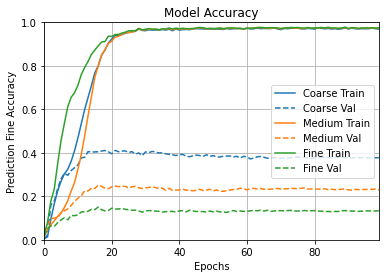

In [21]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

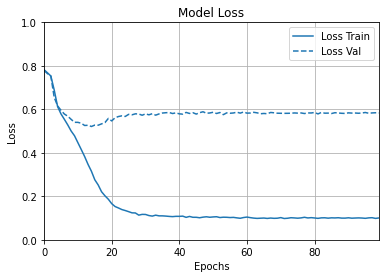

In [22]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [23]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : MarginLoss(),
                          'prediction_medium' : MarginLoss(),
                          'prediction_coarse' : MarginLoss()},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [24]:
results = final_model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
model_predictions = final_model.predict(test_dataset)

182/182 [==============================] - 24s 120ms/step - loss: 0.5811 - prediction_coarse_loss: 0.5524 - prediction_medium_loss: 0.5892 - prediction_fine_loss: 0.6412 - prediction_coarse_accuracy: 0.3776 - prediction_medium_accuracy: 0.2295 - prediction_fine_accuracy: 0.1336
1. loss ==> 0.5810928344726562
2. prediction_coarse_loss ==> 0.5523945689201355
3. prediction_medium_loss ==> 0.5892480611801147
4. prediction_fine_loss ==> 0.6411954760551453
5. prediction_coarse_accuracy ==> 0.3776320219039917
6. prediction_medium_accuracy ==> 0.22954781353473663
7. prediction_fine_accuracy ==> 0.13358646631240845


In [25]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
    return y_true, y_pred

In [26]:
predictions = []
predictions.append(predict_from_pipeline(final_model, test_dataset))

In [27]:
dataset= {'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [28]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 2  0  0 ...  0  0  0]
 [ 0 13  0 ...  0  1  0]
 [ 0  2 16 ...  0  0  0]
 ...
 [ 0  0  0 ...  4  6  1]
 [ 0  0  0 ...  0 45  3]
 [ 0  0  0 ...  1  1  4]]

  • MEDIUM LEVEL 
[[ 3  1  0 ...  0  0  0]
 [ 0 13  0 ...  0  0  0]
 [ 0  0  4 ...  0  0  0]
 ...
 [ 0  0  0 ... 25  0  2]
 [ 0  0  0 ...  0 11  0]
 [ 0  1  0 ...  0  0  4]]

  • FINE LEVEL 
[[2 0 3 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 7]]

  • Classification Report 


  • COARSE LEVEL 


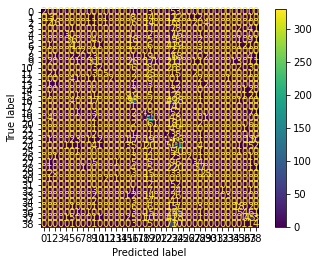

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    1.00000   0.14286   0.25000        14
           1    0.40625   0.19403   0.26263        67
           2    0.55172   0.24242   0.33684        66
           3    0.00000   0.00000   0.00000        35
           4    0.60000   0.10345   0.17647        29
           5    0.59016   0.36000   0.44720       100
           6    0.47826   0.09735   0.16176       113
           7    0.66667   0.13333   0.22222        15
           8    0.28571   0.03226   0.05797        62
           9    0.32292   0.26271   0.28972       118
          10    0.28571   0.03448   0.06154        58
          11    0.55556   0.10638   0.17857        47
          12    1.00000   0.08696   0.16000        23
          13    0.00000   0.00000   0.00000        12
          14    0.00000   0.00000   0.00000        12
          15    0.56250   0.13636   0.21951        66
          16    0.35185   0.48223   0.40685       197
          17    0.00000   0

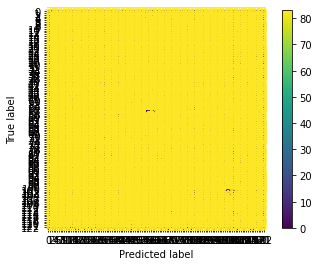

              precision    recall  f1-score   support

           0    0.18750   0.15000   0.16667        20
           1    0.26000   0.48148   0.33766        27
           2    0.50000   0.36364   0.42105        11
           3    0.20000   0.22222   0.21053         9
           4    0.00000   0.00000   0.00000        14
           5    0.40909   0.21429   0.28125        42
           6    0.00000   0.00000   0.00000        13
           7    0.60000   0.60000   0.60000        15
           8    0.00000   0.00000   0.00000        16
           9    0.16129   0.31250   0.21277        16
          10    0.00000   0.00000   0.00000        16
          11    0.21739   0.31250   0.25641        16
          12    0.32000   0.22857   0.26667        35
          13    0.06250   0.05882   0.06061        17
          14    0.20000   0.11111   0.14286         9
          15    0.21739   0.12195   0.15625        41
          16    0.18750   0.30000   0.23077        10
          17    0.28571   0

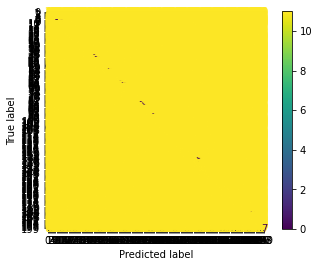

              precision    recall  f1-score   support

           0    0.18182   0.13333   0.15385        15
           1    0.08333   0.06250   0.07143        16
           2    0.05263   0.06250   0.05714        16
           3    0.00000   0.00000   0.00000        13
           4    0.20000   0.28571   0.23529         7
           5    0.00000   0.00000   0.00000         4
           6    0.26667   0.25000   0.25806        16
           7    0.06667   0.10000   0.08000        10
           8    0.00000   0.00000   0.00000        12
           9    0.33333   0.45455   0.38462        11
          10    0.00000   0.00000   0.00000        17
          11    0.61111   0.84615   0.70968        13
          12    0.11538   0.25000   0.15789        12
          13    0.00000   0.00000   0.00000        13
          14    0.00000   0.00000   0.00000        16
          15    0.33333   0.26667   0.29630        15
          16    0.17647   0.30000   0.22222        10
          17    0.12500   0

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
metrics.lvl_wise_metric(true_label,pred_label)

In [30]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.23259118628466227 
Hierarchical Recall = 0.2921412955931423 
Hierarchical F1-Score = 0.25521749374010333 
Consistency =  0.32205730065585086 
Exact Match =  0.07904729030031067
